In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import datetime
from tueplots import bundles
from tueplots.constants.color.palettes import rgb
from matplotlib import font_manager

read_path = r'C:\Users\Julia\Desktop\Data-Literacy\Data\joined_survey_article_standardized_median.csv'
df = pd.read_csv(read_path, delimiter=';', header=0)
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")

df["SPD"] = pd.to_numeric(df["SPD"], errors='coerce')
df["Union"] = pd.to_numeric(df["Union"], errors='coerce')
df["Grüne"] = pd.to_numeric(df["Grüne"], errors='coerce')
df["FDP"] = pd.to_numeric(df["FDP"], errors='coerce')
df["AfD"] = pd.to_numeric(df["AfD"], errors='coerce')
df["Linke"] = pd.to_numeric(df["Linke"], errors='coerce')

In [14]:
time_after = 4*7
time_before = 16*7

In [15]:
# filter data: get highest article values, long time before, short time after
dates_max = df.sort_values('standardized_war_articles').nlargest(10, 'standardized_war_articles')
results = {}
plot_parties = ["Union", "SPD", "Grüne"]

for date in dates_max['date']:
    df_res = pd.DataFrame(columns=["R2 Reg", "RMSE", "RMSPE", "Mean diff"])
    results.update({date: df_res})
    date_after = date + datetime.timedelta(days=time_after)
    date_before = date - datetime.timedelta(days=time_before)
    total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]
    regression_df = total_df[total_df["date"] < date]
    pred_df = total_df[total_df["date"] >= date]
    for party in ["Union", "SPD", "Grüne", "FDP", "AfD", "Linke"]:
        total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]
        regression_df = total_df[total_df["date"] < date]
        pred_df = total_df[total_df["date"] >= date]
        regression_df = regression_df[(~regression_df[party].isna())]
        pred_df = pred_df[(~pred_df[party].isna())]
        if regression_df.empty or pred_df.empty:
            continue
        X = regression_df.index.values
        Y = regression_df[party]
        # fit model
        model = sm.OLS(Y, X).fit()
        #print(model.summary())
        r2_reg = model.rsquared
        # get values for regression
        y_reg = model.predict(X)
        mse_reg = rmse(Y, y_reg)
        # get values for prediction
        X_pred = pred_df.index.values
        Y_pred = pred_df[party]
        y_pred = model.predict(X_pred)
        mse_pred = rmse(Y_pred, y_pred)
        df_res.loc[party, "RMSE"] = round(mse_reg, 2)
        df_res.loc[party, "RMSPE"] = round(mse_pred, 2)
        df_res.loc[party, "R2 Reg"] = round(r2_reg, 3)
        # calculate difference
        real_values = pred_df[party]
        diff = real_values - y_pred
        mean_diff = np.mean(diff)
        df_res.loc[party, "Mean diff"] = round(mean_diff, 2)

In [16]:
for date in dates_max['date']:
    print(date.strftime("%d.%m.%Y"))
    print(results[date])

28.03.2003
      R2 Reg  RMSE RMSPE Mean diff
Union  0.999  1.14  1.36     -1.17
SPD    0.998  1.14  2.23      2.19
Grüne  0.996  0.73  0.67      0.17
FDP    0.987  0.66  0.51     -0.11
Linke   0.98  0.48  0.43     -0.15
18.03.2022
      R2 Reg  RMSE RMSPE Mean diff
Union  0.984  3.01  4.57      4.52
SPD    0.997  1.31  2.55      2.54
Grüne  0.999   0.5  3.92       3.8
FDP    0.993  0.88  0.91     -0.85
AfD    0.994  0.91  1.02      1.01
Linke  0.998  0.25  0.41      -0.4
04.04.2003
      R2 Reg  RMSE RMSPE Mean diff
Union  0.999  1.18  1.28     -0.64
SPD    0.998  1.25  1.74      1.39
Grüne  0.996  0.69  0.75      0.04
FDP    0.987  0.65   0.7      0.29
Linke  0.981  0.47  0.51      0.12
07.04.2022
      R2 Reg  RMSE RMSPE Mean diff
Union  0.993  2.17   3.1      2.96
SPD    0.996  1.48  2.05       2.0
Grüne  0.996  0.97  3.99      3.98
FDP    0.998  0.43   0.5     -0.03
AfD    0.998  0.56  0.71      0.67
Linke  0.996  0.29  0.79     -0.68
03.03.2022
      R2 Reg  RMSE RMSPE Mean diff


In [17]:
# get prediction interval
def ols_quantile(m, X, q):
  # m: OLS model.
  # X: X matrix.
  # q: Quantile.
  #
  # Set alpha based on q.
  a = q * 2
  if q > 0.5:
    a = 2 * (1 - q)
  predictions = m.get_prediction(X)
  frame = predictions.summary_frame(alpha=a)
  if q > 0.5:
    return frame.obs_ci_upper
  return frame.obs_ci_lower

In [18]:
def plot_reg(parties, date):
    # plot
    colors = {
        "Union": 'gray',
        "SPD": rgb.tue_ocre,
        "Grüne": rgb.tue_green,
        "Linke": rgb.tue_violet,
        "AfD": rgb.tue_lightblue,
        "FDP": rgb.tue_lightorange
    }
    colors_reg = {
        "Union": rgb.tue_dark,
        "SPD": rgb.tue_red,
        "Grüne": rgb.tue_darkgreen,
        "Linke": rgb.tue_violet,
        "AfD": rgb.tue_blue,
        "FDP": rgb.tue_orange
    }
    
    plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
    fig, ax1 = plt.subplots() 
    plt.xticks(rotation=45)
    ax1.set_xticklabels([]) 
    #ax1.set_xlabel('Date') 
    ax1.set_ylabel('Election Survey %')
    ax1.grid(color=rgb.tue_gray, alpha = 0.2)
    date_after = date + datetime.timedelta(days=time_after)
    date_before = date - datetime.timedelta(days=time_before)
    total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]
    for date_test in total_df['date'][::-1]:
        if (date_test == date):
            break
        date_before_high = date_test
    time_between = date - date_before_high
    
    regression_df = total_df[total_df["date"] < date]
    pred_df = total_df[total_df["date"] >= date - time_between] # include date in prediction line
    
    legend_labels = [] 
    legend = True
    for party in parties:
        regression_df = regression_df[(~regression_df[party].isna())]
        pred_df = pred_df[(~pred_df[party].isna())]
        if regression_df.empty or pred_df.empty:
            continue
        X = regression_df.index.values
        Y = regression_df[party]
        # fit model
        model = sm.OLS(Y, X).fit()
        # get values for regression
        y_reg = model.predict(X)
        # get values for prediction
        X_pred = pred_df.index.values
        Y_pred = pred_df[party]
        y_pred = model.predict(X_pred)
      
        ax1.plot(total_df['date'], total_df[party], color=colors[party], marker='.', linestyle='', label=f'{party} - Obervation')
        ax1.plot(regression_df['date'], y_reg, color = colors_reg[party], label=f'{party} - Regressionline')
        ax1.plot(pred_df['date'], y_pred, linestyle = '--', color = colors_reg[party], label=f'{party} - Predictionline')
        
       
        # confidence interval
        pred = model.get_prediction(X).summary_frame()
        ax1.fill_between(regression_df['date'], pred['mean_ci_lower'], pred['mean_ci_upper'], color=colors_reg[party], alpha=0.2, label = f'{party} - Confidence Interval')
    
        # prediction interval
        upper = ols_quantile(model, X_pred, 0.95)
        lower = ols_quantile(model, X_pred, 0.05)
        ax1.fill_between(pred_df['date'], upper, lower, color=colors_reg[party], alpha=0.1, label = f'{party} - Prediction Interval')
        
        # prediction interval
        upper = ols_quantile(model, X, 0.95)
        lower = ols_quantile(model, X, 0.05)
        ax1.fill_between(regression_df['date'], upper, lower, color=colors_reg[party], alpha=0.1)
    
        if legend:
            legend_labels.extend(['Observation', 'Regression', 'Prediction', 'Confidence Interval', 'Prediction Interval'])  # Add labels for "Union" party, confidence, and prediction intervals
            legend = False
    
    plt.legend(legend_labels, bbox_to_anchor=(0.85, 1.3), ncol=2, frameon=False)
    plt.show()

To generate plots for a spectic date from the results table, change the index (and optionally parties) here.

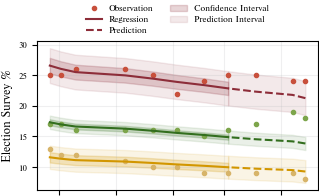

In [19]:
date = dates_max.iloc[1]['date']
plot_reg(["SPD", "Grüne", "FDP"], date)

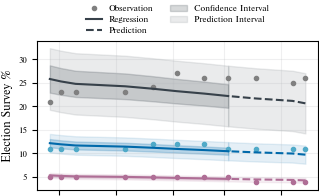

In [20]:
plot_reg(["Union", "AfD", "Linke"], date)

In [21]:
# plot compare RMSE with RMSPE and Mean diff -> change date to see plots for all results
def table_plot(date):
    data = results[date]
    
    colours_party = {'SPD': rgb.tue_red, 'Union': rgb.tue_dark, 'Grüne': rgb.tue_darkgreen,
                       'FDP': rgb.tue_lightorange, 'AfD': rgb.tue_blue, 'Linke': rgb.tue_violet}
    
    bar_width = 0.25
    bar_positions = np.arange(len(data.index.values))
    
    plt.rcParams.update(bundles.icml2022(column='half', nrows=3, ncols=2, usetex=False))
    
    fig, ax1 = plt.subplots()
    
    # Iraq War Plot
    bars1 = ax1.bar(bar_positions - bar_width, data['RMSE'], bar_width, color=[colours_party[partei] for partei in data.index.values], alpha=1, label='RMSE')
    bars2 = ax1.bar(bar_positions, data['RMSPE'], bar_width, color=[colours_party[partei] for partei in data.index.values], alpha=0.5, label='RMSPE')
    bars3 = ax1.bar(bar_positions + bar_width, data['Mean diff'], bar_width, color=[colours_party[partei] for partei in data.index.values], alpha=0.25, label='Mean diff')
    ax1.set_xticks(bar_positions)
    ax1.set_ylim(min(min(data['RMSE']), min(data['RMSPE']), min(data['Mean diff'])) -0.1 ,
                max(max(data['RMSE']), max(data['RMSPE']), max(data['Mean diff'])) + 0.4)  # Adjusted ylim
    #ax1.set_xticklabels(df_iraq['Party'])
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_title(date.strftime("%d.%m.%Y"))
    #ax1.set_xticklabels([]) 
    ax1.set_xticks([])
    ax1.set_yticks([])
    # Annotate each bar with its value
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2, height, '%.1f' % height, ha='center', va='bottom',  fontsize=5)
    
    #plt.tight_layout()
    plt.show()

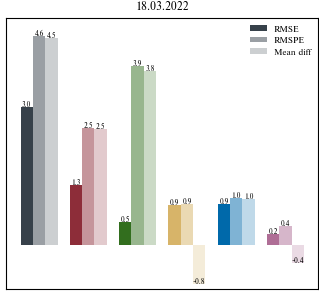

In [22]:
table_plot(date)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


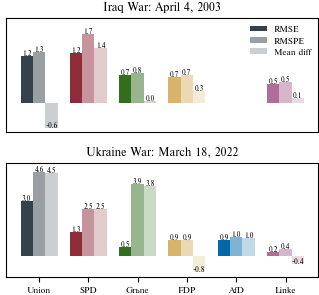

In [24]:
# plot compare RMSE with RMSPE and Mean diff -> for report
data_iraq = {
    'Party': ['Union', 'SPD', 'Grüne', 'FDP', 'AfD', 'Linke'],
    'RMSE Iraq': [1.18, 1.25, 0.69, 0.65, None, 0.47],  # None for missing values
    'RMSPE Iraq': [1.28, 1.74, 0.75, 0.7, None, 0.51],
    'Mean diff Iraq': [-0.64, 1.39, 0.04, 0.29, None, 0.12],  # None for missing values
}
df_iraq = pd.DataFrame(data_iraq)

data_ukraine = {
    'Party': ['Union', 'SPD', 'Grüne', 'FDP', 'AfD', 'Linke'],
    'RMSE Ukraine': [3.01, 1.31, 0.5, 0.88, 0.91, 0.25],
    'RMSPE Ukraine': [4.57, 2.55, 3.92, 0.91, 1.02, 0.41],
    'Mean diff Ukraine': [4.52, 2.54, 3.8, -0.85, 1.01, -0.4]
}
df_ukraine = pd.DataFrame(data_ukraine)

colours_party = {'SPD': rgb.tue_red, 'Union': rgb.tue_dark, 'Grüne': rgb.tue_darkgreen,
                   'FDP': rgb.tue_lightorange, 'AfD': rgb.tue_blue, 'Linke': rgb.tue_violet}

bar_width = 0.25
bar_positions = np.arange(len(df_iraq['Party']))

plt.rcParams.update(bundles.icml2022(column='half', nrows=3, ncols=2, usetex=False))

fig, (ax1, ax2) = plt.subplots(2,1)  # 1 row, 2 columns

# Iraq War Plot
bars1 = ax1.bar(bar_positions - bar_width, df_iraq['RMSE Iraq'], bar_width, color=[colours_party[partei] for partei in df_iraq['Party']], alpha=1, label='RMSE')
bars2 = ax1.bar(bar_positions, df_iraq['RMSPE Iraq'], bar_width, color=[colours_party[partei] for partei in df_iraq['Party']], alpha=0.5, label='RMSPE')
bars3 = ax1.bar(bar_positions + bar_width, df_iraq['Mean diff Iraq'], bar_width, color=[colours_party[partei] for partei in df_iraq['Party']], alpha=0.25, label='Mean diff')
ax1.set_xticks(bar_positions)
ax1.set_ylim(min(min(df_iraq['RMSE Iraq']), min(df_iraq['RMSPE Iraq']), min(df_iraq['Mean diff Iraq'])) -0.1 ,
            max(max(df_iraq['RMSE Iraq']), max(df_iraq['RMSPE Iraq']), max(df_iraq['Mean diff Iraq'])) + 0.4)  # Adjusted ylim
#ax1.set_xticklabels(df_iraq['Party'])
ax1.legend(loc='upper right', frameon=False)
ax1.set_title('Iraq War: April 4, 2003')
#ax1.set_xticklabels([]) 
ax1.set_xticks([])
ax1.set_yticks([])
# Annotate each bar with its value
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height, '%.1f' % height, ha='center', va='bottom',  fontsize=5)

# Ukraine War Plot
bars1 = ax2.bar(bar_positions - bar_width, df_ukraine['RMSE Ukraine'], bar_width, color=[colours_party[partei] for partei in df_ukraine['Party']], alpha=1, label='RMSE')
bars2 = ax2.bar(bar_positions, df_ukraine['RMSPE Ukraine'], bar_width, color=[colours_party[partei] for partei in df_ukraine['Party']], alpha=0.5, label='RMSPE')
bars3 = ax2.bar(bar_positions + bar_width, df_ukraine['Mean diff Ukraine'], bar_width, color=[colours_party[partei] for partei in df_ukraine['Party']], alpha=0.25, label='Mean diff')
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(df_ukraine['Party'])
#ax2.set_xticks([])
ax2.set_yticks([])
#ax1.legend(loc='upper right')
ax2.set_ylim(min(min(df_ukraine['RMSE Ukraine']), min(df_ukraine['RMSPE Ukraine']), min(df_ukraine['Mean diff Ukraine'])) -0.25,
            max(max(df_ukraine['RMSE Ukraine']), max(df_ukraine['RMSPE Ukraine']), max(df_ukraine['Mean diff Ukraine'])) + 0.5)  # Adjusted ylim

ax2.set_title('Ukraine War: March 18, 2022')

# Annotate each bar with its value
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height, '%.1f' % height, ha='center', va='bottom',  fontsize=5)

#plt.tight_layout()
plt.savefig('Combined_Plots.pdf', format='pdf')
plt.show()